# <center>Training a Decentralized Machine Learning Model</center>

In this phase, we will train a decentralized machine learning (ML) model using Horizontal Federated Learning (HFL), where five clients collaboratively train a model on fraud transaction data without sharing their raw data. Each client retains its dataset locally, and only model updates are exchanged, ensuring privacy and compliance with data protection regulations.

Unlike centralized ML, where data is aggregated in a single location, HFL addresses privacy concerns, data silos, and regulatory constraints. After benchmarking the centralized model, we will compare its performance, efficiency, and trade-offs against the federated approach to assess its viability in fraud detection.

--- 

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

torch: 2.6.0
flwr : 1.14.0



--------

## Loading Dependencies

In [2]:
import os
import sys
sys.path.append("../")

import ray

import torch
import torch.nn as nn

from logging import ERROR

from flwr.common import ndarrays_to_parameters, Context 
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg 
from flwr.simulation import run_simulation 

from src.paths import DATA_DIR
from src.config import NUM_CLASSES, NUM_FEATURES, SERVER_CONFIG
from src.train_decentralized import train_model
from src.FL_client import BankFLClient
from src.FL_server import weighted_average, evaluate, evaluate_transformer
from src.local_utility import load_client_data, load_test_data, get_weights, set_weights
from src.local_utility import set_device, set_seed

------

In [3]:
DEVICE = set_device()
set_seed()

In [4]:
# Load Datasets
num_clients = SERVER_CONFIG['num_clients']
train_sets = []
val_sets = []

for i in range(num_clients):
    train_set, val_set = load_client_data(i)
    train_sets.append(train_set)
    val_sets.append(val_set)

test_set = load_test_data()

------

In [25]:
# Define Model 

class FraudDetectionModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = nn.Sequential(

            # 1st hidden layer
            nn.Linear(num_features, 25),
            nn.ReLU(),

            # 2nd hidden layer
            nn.Linear(25, 15),
            nn.ReLU(),

            # output layer
            nn.Linear(15, num_classes)
        )

    def forward(self, x):
        logits = self.all_layers(x)
        return logits

----

In [30]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    model = FraudDetectionModel(num_features=NUM_FEATURES, num_classes=NUM_CLASSES) # initialize model
    client_train = train_sets[partition_id] #<-- Assign partitioned training dataset
    client_val = val_sets[partition_id]     #<-- Assign partitioned validation dataset
    
    return BankFLClient(model, client_train, client_val).to_client()

client = ClientApp(client_fn)

In [31]:
model = FraudDetectionModel(num_features=NUM_FEATURES, num_classes=NUM_CLASSES)
params = ndarrays_to_parameters(get_weights(model))

def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<--- Sample 100% of available clients for training
        fraction_evaluate=1.0,            #<--- Sample 100% of available clients for evaluation
        initial_parameters=params,        #<--- Initial model parameters
        evaluate_fn=evaluate,             #<--- Global evaluation function
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )

    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=SERVER_CONFIG['num_rounds']) #<--- no. of federated rounds
    
    return ServerAppComponents(strategy = strategy, config = sever_config)


# Wrap the server function in a ServerApp, and instantiate it
server = ServerApp(server_fn = server_fn) 

----- 

Set up our backend configurations before running the simulation

> - `init_args`: filter logging coming from the Simulation Engine so it's more readable in notebooks
> - `client_resources`: by default, allocate to each client 1x CPU and 0x GPUs. However, when running on GPU, assign an entire GPU for each client

In [32]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": False
    },
    "client_resources": {
        "num_cpus": 1, 
        "num_gpus": 0.0
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-03-16 16:46:45,032	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-16 16:46:45,478	INFO packaging.py:575 -- Creating a file package for local module 'C:\Users\Emeka Obiefuna\Desktop\Data Science\Personal Projects\MLC - Research Work\MLC-FedML'.
2025-03-16 16:46:45,698	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_3e228331d17315ea.zip' (4.70MiB) to Ray cluster...
2025-03-16 16:46:45,735	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_3e228331d17315ea.zip'.
INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.6793443171345458, {'accuracy': 0.6514118792599806}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 


Accuracy: 0.80 | Recall: 0.68 | Precision: 0.72 | ROC-AUC: 0.85

 ___________________________________________________________________________________________________ 



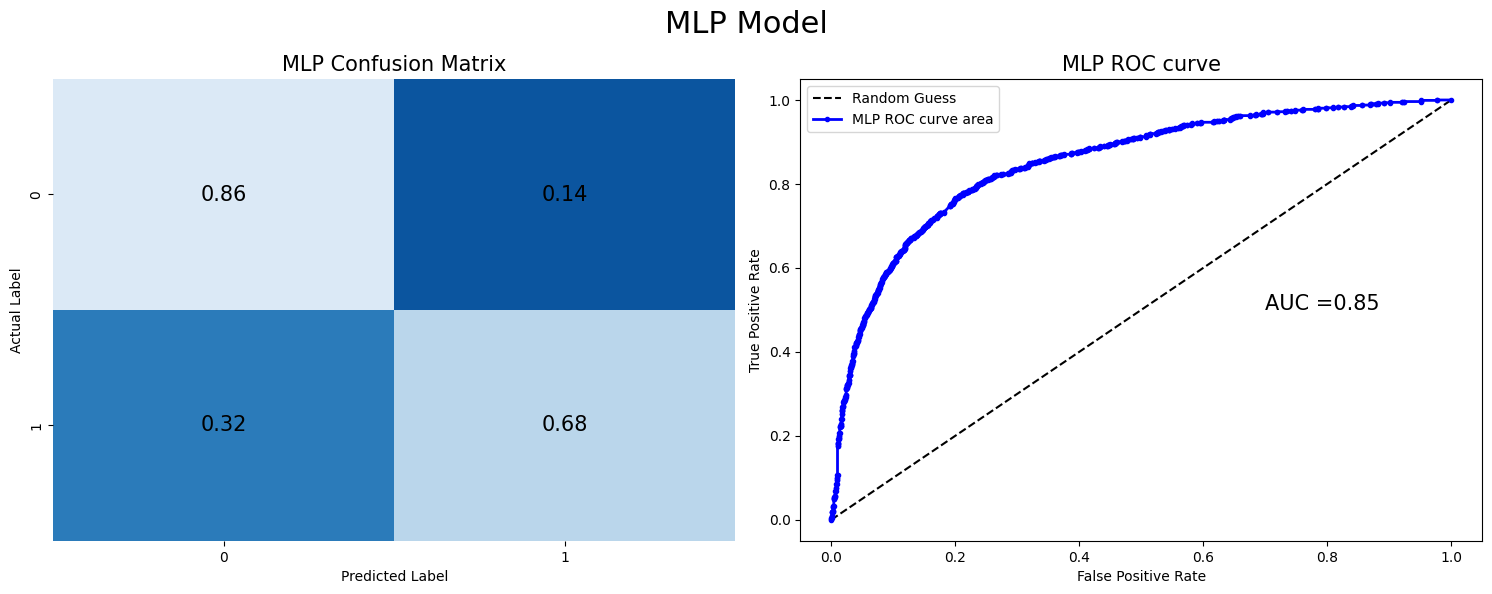

INFO :      fit progress: (20, 0.4932202587322313, {'accuracy': 0.7984420642648491}, 180.68975639995188)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


___________________________________________________________________________________________________ 

Federated Learning Classification Report
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      2007
           1       0.72      0.68      0.70      1074

    accuracy                           0.80      3081
   macro avg       0.78      0.77      0.77      3081
weighted avg       0.80      0.80      0.80      3081

___________________________________________________________________________________________________


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 181.19s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.4146485918582849
INFO :      		round 2: 0.40966718583987416
INFO :      		round 3: 0.40609553096510015
INFO :      		round 4: 0.41246075559637796
INFO :      		round 5: 0.41859446773879844
INFO :      		round 6: 0.42291680697008227
INFO :      		round 7: 0.43496690481243194
INFO :      		round 8: 0.4393388090518851
INFO :      		round 9: 0.4427048313878986
INFO :      		round 10: 0.44573917244949673
INFO :      		round 11: 0.45325898514891794
INFO :      		round 12: 0.46844885736845976
INFO :      		round 13: 0.462973431393414
INFO :      		round 14: 0.4752855782872922
INFO :      		round 15: 0.4741816376330508
INFO :      		round 16: 0.48537180604243807
INFO :      		round 17: 0.47499532595120997
INFO :      		round 18: 0.48231939274363783
INFO :      		round 19: 0.4884892

In [33]:
project_root =  os.path.abspath("..")
data_dir = os.path.abspath(DATA_DIR)

ray.shutdown()

ray.init(runtime_env={"working_dir": project_root, 'excludes': ['data']})

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = SERVER_CONFIG.get("num_clients"), #<-- number of clients (5)
    backend_config=backend_setup
)

----

----

<br><p>

## Federated Transformer

<br><p> 

Let's now explore the integration of transformer-based model into federated learning frameworks to see if it can enhance performance on our non-IID financial data, addressing challenges in privacy-preserving fraud detection.

---- 

In [34]:
from src.local_utility import TransformerModel
from src.config import INPUT_DIM, NUM_CLASSES, NUM_HEADS, NUM_LAYERS, DROPOUT, DIM_FEEDFORWARD

In [35]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads, num_layers, dim_feedforward, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, dim_feedforward)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_feedforward, 
            nhead=num_heads, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
            batch_first=True  # Set batch_first to True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(dim_feedforward, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.transformer_encoder(x)
        x = x.squeeze(1)  # Remove sequence dimension
        x = self.fc(x)
        return x #torch.sigmoid(x)

# Hyperparameters
# input_dim = 51 #X_train.shape[1]
# num_classes = 2
# num_heads = 8
# num_layers = 2
# dim_feedforward = 64
# dropout = 0.1

----

In [36]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    
    # initialize model
    transformer_model =TransformerModel(INPUT_DIM, NUM_CLASSES, NUM_HEADS, NUM_LAYERS, DIM_FEEDFORWARD, DROPOUT)
    client_train = train_sets[partition_id] #<-- Assign partitioned training dataset
    client_val = val_sets[partition_id]     #<-- Assign partitioned validation dataset
    
    return BankFLClient(transformer_model, client_train, client_val).to_client()

client = ClientApp(client_fn)

In [37]:
transformer_model= TransformerModel(INPUT_DIM, NUM_CLASSES, NUM_HEADS, NUM_LAYERS, DIM_FEEDFORWARD, DROPOUT)

params = ndarrays_to_parameters(get_weights(transformer_model))

def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<--- Sample 100% of available clients for training
        fraction_evaluate=1.0,            #<--- Sample 100% of available clients for evaluation
        initial_parameters=params,        #<--- Initial model parameters
        evaluate_fn=evaluate_transformer,             #<--- Global evaluation function
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )

    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=SERVER_CONFIG['num_rounds']) #<--- no. of federated rounds
    
    return ServerAppComponents(strategy = strategy, config = sever_config)


# Wrap the server function in a ServerApp, and instantiate it
server = ServerApp(server_fn = server_fn) 

In [38]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": False
    },
    "client_resources": {
        "num_cpus": 1, 
        "num_gpus": 0.0
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-03-16 16:54:01,536	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-16 16:54:01,924	INFO packaging.py:575 -- Creating a file package for local module 'C:\Users\Emeka Obiefuna\Desktop\Data Science\Personal Projects\MLC - Research Work\MLC-FedML'.
2025-03-16 16:54:02,163	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_00c0201fa47c97a5.zip' (4.71MiB) to Ray cluster...
2025-03-16 16:54:02,199	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_00c0201fa47c97a5.zip'.
INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.6608850165289275, {'accuracy': 0.6306394027913015}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 


Accuracy: 0.81 | Recall: 0.71 | Precision: 0.73 | ROC-AUC: 0.87

 ___________________________________________________________________________________________________ 



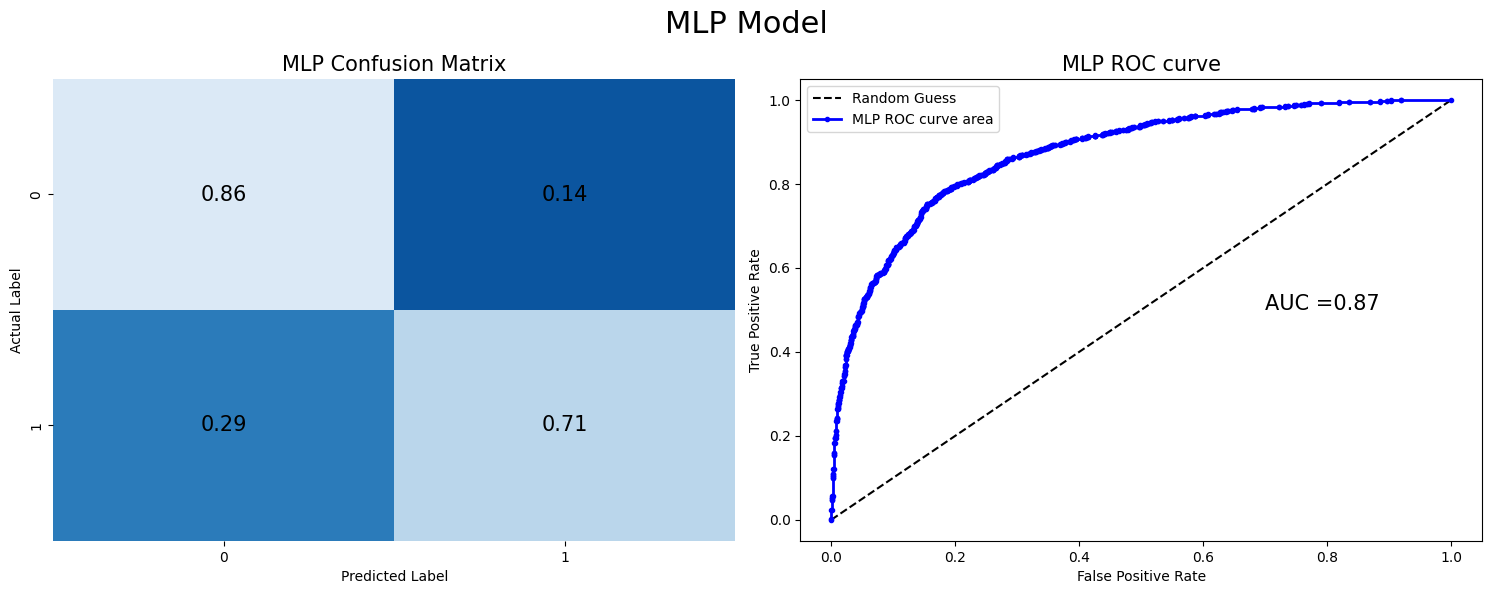

INFO :      fit progress: (20, 0.41659312953754346, {'accuracy': 0.8088283024991886}, 375.2142374999821)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


___________________________________________________________________________________________________ 

Federated Learning Classification Report
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2007
           1       0.73      0.71      0.72      1074

    accuracy                           0.81      3081
   macro avg       0.79      0.79      0.79      3081
weighted avg       0.81      0.81      0.81      3081

___________________________________________________________________________________________________


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 376.17s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5300501012102831
INFO :      		round 2: 0.4791989257765842
INFO :      		round 3: 0.4170964422392464
INFO :      		round 4: 0.41011451391993786
INFO :      		round 5: 0.4128440216457719
INFO :      		round 6: 0.4109229345125242
INFO :      		round 7: 0.4099794961480743
INFO :      		round 8: 0.40740832997141263
INFO :      		round 9: 0.40804546717511786
INFO :      		round 10: 0.407776242148997
INFO :      		round 11: 0.40746078523285717
INFO :      		round 12: 0.40886407058370916
INFO :      		round 13: 0.40963688923384306
INFO :      		round 14: 0.4060431514161469
INFO :      		round 15: 0.40962118045084894
INFO :      		round 16: 0.41047836499164114
INFO :      		round 17: 0.4108898006446775
INFO :      		round 18: 0.4082362736621317
INFO :      		round 19: 0.40933767048

In [39]:
project_root =  os.path.abspath("..")

ray.shutdown()

ray.init(runtime_env={"working_dir": project_root, 'excludes': ['data']})

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = SERVER_CONFIG.get("num_clients"), #<-- number of clients (5)
    backend_config=backend_setup
)